In [109]:
########################################
## import packages
########################################
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import activations
from keras import backend as K
import pickle
from prep import preprocess
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score,accuracy_score
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import concatenate
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim import models
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [36]:

MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set


In [37]:
word2vec = KeyedVectors.load_word2vec_format('/Users/shivamlalakiya/Desktop/Projects/Duplicate_questions_Quora/GoogleNews-vectors-negative300.bin', binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.key_to_index))

Found 3000000 word vectors of word2vec


## process texts in datasets


In [72]:
text_1 = []
text_2 = []
labels = []

p = preprocess()

with codecs.open('/Users/shivamlalakiya/Desktop/Projects/Duplicate_questions_Quora/train.csv', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        text_1.append(p.text_to_worldlist(values[3]))
        text_2.append(p.text_to_worldlist(values[4]))
        labels.append(int(values[5])) 

In [79]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_1 + text_2)

with open('/Users/shivamlalakiya/Desktop/Projects/Duplicate_questions_Quora/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

sequences_1 = tokenizer.texts_to_sequences(text_1)
sequences_2 = tokenizer.texts_to_sequences(text_2)

In [84]:
data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (404290, 30)
Shape of label tensor: (404290,)


## Embedding

In [28]:
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.key_to_index:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


/var/folders/97/xxfyhrd974n7y618tr2tkg0h0000gn/T/ipykernel_47251/1934822239.py:6: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_matrix[i] = word2vec.word_vec(word)


Null word embeddings: 37391


In [29]:
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

## Model

In [30]:
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1,activation= 'sigmoid')(merged)

In [31]:
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

In [32]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model = Model(inputs=[sequence_1_input, sequence_2_input],  outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=20, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

bst_val_score = min(hist.history['val_loss'])


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 300)      25655700    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 181)          348968      ['embedding_1[0][0]',      

In [34]:
model.save('LSTM_model')

INFO:tensorflow:Assets written to: LSTM_model/assets


## Deciding the Threshold

In [87]:
model = tf.keras.models.load_model('/Users/shivamlalakiya/Desktop/Projects/Duplicate_questions_Quora/LSTM_model', compile=False)
pred = model.predict([data_1, data_2], batch_size = 8192, verbose = 1)
pred += model.predict([data_2, data_2], batch_size = 8192, verbose = 1)
pred /= 2

50/50 [==============================] - 82s 2s/step


In [95]:
df = pd.read_csv('/Users/shivamlalakiya/Desktop/Projects/Duplicate_questions_Quora/train.csv')
final = pd.DataFrame({'label':df['is_duplicate'], 'prediction':pred.ravel()})
final

,label,prediction
0,0,0.306899
1,0,0.285184
2,0,0.277689
3,0,0.138951
4,0,0.242688
...,...,...
404285,0,0.015776
404286,1,0.678957
404287,0,0.286156
404288,0,0.337355


In [115]:
from sklearn.metrics import accuracy_score
thr = 0
f1_list = []
acc_list = []
threshold = []
for i in range(10):
    thr += 0.1
    pl = []
    for row in range(len(final)):
        if final['prediction'].iloc[row] > thr:
            pl.append(1)
        else:
            pl.append(0)

    acc = accuracy_score(final['label'], pl)
    f1 = f1_score(final['label'], pl)

    print(thr,f1,acc)
    f1_list.append(f1)
    acc_list.append(acc)
    threshold.append(thr)

0.1 0.5545403837572513 0.40739073437384055
0.2 0.6339220717867228 0.5783299116970492
0.30000000000000004 0.7537671763326179 0.7798016275445844
0.4 0.7583451394753187 0.8287071161789804
0.5 0.6960104553023609 0.8153182121744292
0.6 0.6115327827771332 0.7871948353904376
0.7 0.5219372662151921 0.7581661678498108
0.7999999999999999 0.428447964298622 0.7300972074500977


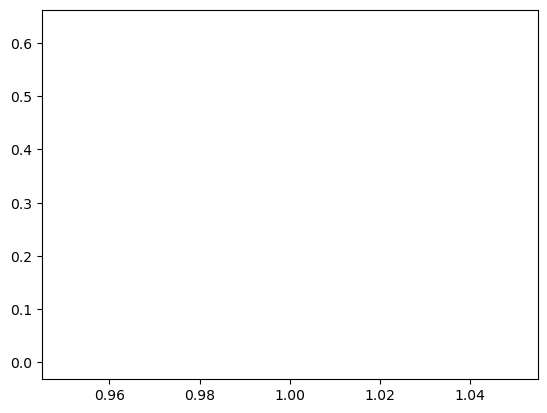

In [ ]:
plt.plot(threshold, f1_list, label = "F1 Score")
plt.plot(threshold, acc_list, label = "Accuracy")
plt.show()